In [11]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name):
    v = numpy.loadtxt(file_name)

    u = numpy.array(v[:, 1:3])
    x = numpy.array(v[:, 3:5])

    dt= v[:, -1].mean()
    t = numpy.arange(x.shape[0])*dt*0.001
    
    return u, x, t

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x, wheel_diameter = 34.0*0.001, robot_brace = 80.0*0.001):

    n_steps = x.shape[0]

    left_position = x[:, 0]
    right_position= x[:, 1] 

    distance = 0.5*(left_position + right_position)*wheel_diameter
    angle    = (right_position - left_position)*wheel_diameter / robot_brace

    #zero initial conditions
    distance = distance - distance[0]
    angle    = angle - angle[0]

    x_aug = numpy.zeros((n_steps, 2))
    x_aug[:, 0] = distance
    x_aug[:, 1] = angle

    vel = difference(x_aug[:, 0:2])

    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()
    
    fig, axs = plt.subplots(6, 1, figsize=(8, 2*5))


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control left")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control right")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [m]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1], color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1], color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [rad]")
    axs[3].grid()

    
    axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2], color="red")
    axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2], color="blue")
    axs[4].set_xlabel("time [s]")
    axs[4].set_ylabel("velocity")
    axs[4].grid()

    axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3], color="red")
    axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3], color="blue")
    axs[5].set_xlabel("time [s]")
    axs[5].set_ylabel("angular velocity")
    axs[5].grid()

    #fig.legend()


def matrix_to_c(name, x):

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [12]:
#obtain response
u_result, x_ref, t_result = load_from_file("./data/run_0.log")
x_ref = state_augmentation(x_ref)


#identification
a_est, b_est = LibsControl.recursive_ls_identification(u_result, x_ref)
    
c_est = numpy.zeros((a_est.shape[0]//2, a_est.shape[0]))
for n in range(a_est.shape[0]//2):
    c_est[n][n] = 1.0


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")



n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]



mat_a = 
 [[ 9.99987855e-01 -4.16527201e-06  4.04385747e-01  9.32305974e-03]
 [-2.23876860e-03  1.00023566e+00  3.27223917e+00  2.43503569e-01]
 [-1.21790803e-05 -4.16585078e-06  4.04541740e-01  9.32244954e-03]
 [-2.23876760e-03  2.35659663e-04  3.27223856e+00  2.43503979e-01]] 


mat_b = 
 [[ 5.99366041e-05  2.64221162e-05]
 [-1.55651984e-03  1.09049927e-03]
 [ 5.99242342e-05  2.64121277e-05]
 [-1.55651909e-03  1.09049860e-03]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]] 




<Figure size 640x480 with 0 Axes>

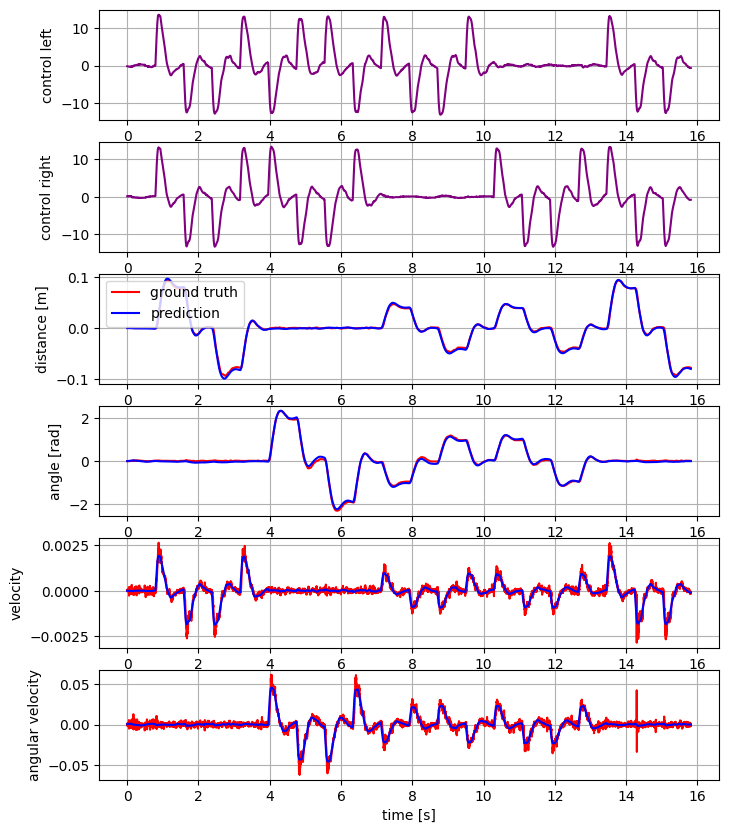

In [13]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, None)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)

#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 4000)


In [14]:
#controller synthetis

#process and observation noise covariance
q_noise = 0.1*numpy.eye(a_est.shape[0]) 
r_noise = 0.1*numpy.eye(c_est.shape[0]) 


#create loss weighting matrices (diagonal)
q = numpy.diag([1.0, 1.0, 0.0, 0.0] )
r = numpy.diag( [100.0, 100.0]) 



#solve LQG controller
lqg = LibsControl.LQGDiscrete(a_est, b_est, c_est, q, r, q_noise, r_noise)

print("controller")
print("k  = \n", lqg.k, "\n")
print("ki = \n", lqg.ki, "\n")
print("f  = \n", lqg.f, "\n")
print("\n\n")



controller
k  = 
 [[ 31.6761722   -6.57258643 -24.70711763  -1.9916012 ]
 [ 30.02261333   6.53345465  73.61637494   3.3383861 ]] 

ki = 
 [[ 0.07065838 -0.0717278 ]
 [ 0.07107809  0.0712947 ]] 

f  = 
 [[0.62277352 0.03759783]
 [0.03759783 0.93222173]
 [0.01218084 0.0920962 ]
 [0.09769884 0.77118034]] 






In [15]:

print(matrix_to_c("mat_a", a_est))
print(matrix_to_c("mat_b", b_est))
print(matrix_to_c("mat_c", c_est))
print(matrix_to_c("k", lqg.k))
print(matrix_to_c("ki", lqg.ki))
print(matrix_to_c("f", lqg.f))

float mat_a[] = {
		0.99998784, -4.165272e-06, 0.40438575, 0.00932306, 
		-0.0022387686, 1.0002357, 3.2722392, 0.24350357, 
		-1.217908e-05, -4.165851e-06, 0.40454173, 0.00932245, 
		-0.0022387677, 0.00023565967, 3.2722385, 0.24350397 };

float mat_b[] = {
		5.9936603e-05, 2.6422116e-05, 
		-0.0015565199, 0.0010904992, 
		5.9924234e-05, 2.6412128e-05, 
		-0.0015565191, 0.0010904986 };

float mat_c[] = {
		1.0, 0.0, 0.0, 0.0, 
		0.0, 1.0, 0.0, 0.0 };

float k[] = {
		31.676172, -6.5725865, -24.707117, -1.9916012, 
		30.022614, 6.5334544, 73.61637, 3.338386 };

float ki[] = {
		0.07065838, -0.0717278, 
		0.07107809, 0.071294695 };

float f[] = {
		0.6227735, 0.03759783, 
		0.03759783, 0.9322217, 
		0.012180835, 0.092096195, 
		0.09769884, 0.77118033 };

